# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

<hr style="border:2px solid gray">

<hr style="border:2px solid blue">

---

# >> Customer Churn Prediction Model

* The goal of a customer churn model is to evaluate the behaviors and attributes of current and former customers to determine trends that lead to churn.
* Several behavioral factors that are widely used in these models are customer purchase intervals, cancellations, follow-up calls, emails, and on-page engagement. Customer attributes, like demographics, location, and income, can also be indicators of churn likelihood.

* Customer churn models are generally created with a classification algorithm, like logistic regression or decision trees. For these algorithms, all categorical data must be converted into a numerical equivalent using techniques like one-hot-encoding.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import basic spark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window


In [2]:
# import pyspark analytic functions
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp


In [3]:
# advanced spark
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


In [4]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


22/10/18 14:37:35 WARN Utils: Your hostname, Andrews-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.39 instead (on interface en0)
22/10/18 14:37:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/18 14:37:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 



In [5]:
# load data
path = "data/mini_sparkify_event_data.json"
sparkify_events = spark.read.json(path)
df = spark.read.json(path)


### Examine Spark Dataframe Schema
* show dataframe columns names & datatype


In [6]:
# print schema
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Examine Unique Elements of Dataframe


In [8]:
df.select('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', \
          'length', 'level', 'location', 'method').show(5)


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------

In [9]:
df.select('page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', \
          'userId').show(5)


+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [10]:
df.select('registration', 'ts').show(5)


+-------------+-------------+
| registration|           ts|
+-------------+-------------+
|1538173362000|1538352117000|
|1538331630000|1538352180000|
|1538173362000|1538352394000|
|1538331630000|1538352416000|
|1538173362000|1538352676000|
+-------------+-------------+
only showing top 5 rows



In [19]:
# print first lines of dataframe
df.show(n=2, truncate=False, vertical=True)


-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

# User Engagement
## >> Explore 'page' events for Unique User Actions


In [24]:
# Create pivot table for user page events
page_events = df.groupBy(['userId']).pivot('page').count().fillna(0)
page_events = page_events.toPandas()

page_events = page_events.rename(columns={"Cancellation Confirmation": "Churn"})
page_events.head()


22/10/18 15:51:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,...,Register,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Registration,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,1,4,7,0,0,0,0,2,11,...,0,52,0,0,0,0,0,5,17,2
1,200002,3,4,8,0,0,5,0,2,20,...,0,7,0,3,0,0,1,6,21,2
2,125,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,...,0,0,1,12,0,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,...,0,4,6,20,0,0,0,41,171,0


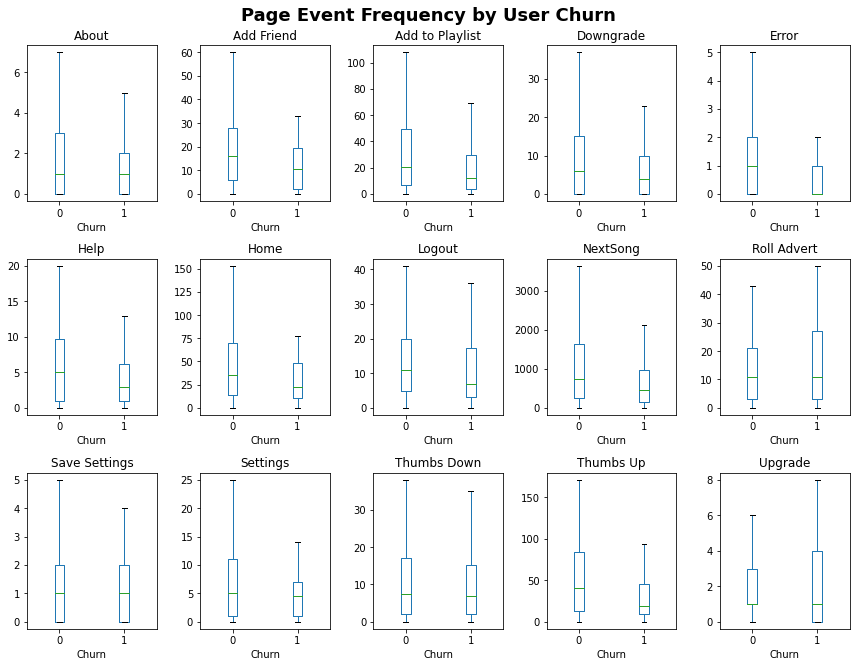

In [29]:
# Visualize page event frequency by churn or not churn
fig = plt.figure(figsize=(12, 12))
page_features = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, col in enumerate(page_features):
    ax = fig.add_subplot(4,5,i+1)
    page_events.boxplot(col, ax=ax, grid=False,  by='Churn', showfliers=False);

fig.suptitle('Page Event Frequency by User Churn', size=18, fontweight = 'bold')
plt.tight_layout()

### Add Datetime Timestamp Column


**Notes: Remove last entry: out of date range.**

## Check for Missing Values

* For string columns, we check for None and null
* For numeric columns, we check for zeroes and NaN


### Remove Missing userId Entries
* Drop entries with missing userId or sessionId

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## >> Examine Change of Subscription Events: 'page'
* Service Cancellation
* Service Downgrade

Change of service events can be found under 'page' column.

In [11]:
# Create a view to run SQL queries
df.createOrReplaceTempView("df_table")


In [12]:
# page events: users with userId & sessionId
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    EXCEPT
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+--------------------+
|                page|
+--------------------+
|           Thumbs Up|
|              Cancel|
|             Upgrade|
|              Logout|
|            NextSong|
|      Submit Upgrade|
|       Save Settings|
|     Add to Playlist|
|            Settings|
|         Thumbs Down|
|Cancellation Conf...|
|         Roll Advert|
|          Add Friend|
|           Downgrade|
|    Submit Downgrade|
+--------------------+



In [13]:
df.filter("artist is Null or artist == ''").select('page').distinct().show()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
| Submit Registration|
+--------------------+
only showing top 20 rows



In [14]:
# pages - user response actions
page_types = df.select('page').dropDuplicates().count()
df.select('page').dropDuplicates().show(page_types)
print("user response actions {}".format(page_types))


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
| Submit Registration|
|            Register|
+--------------------+

user response actions 22


**Missing: 'Submit Registration', 'Register'**

In [15]:
# Check unique category event types
for col in ['page']:
    print(sparkify_events.groupby(col).count().show(30))

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
|            Settings|  1514|
|               Login|  3241|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
|               Error|   258|
|      Submit Upgrade|   159|
| Submit Registration|     5|
|            Register|    18|
+--------------------+------+

None


# >> Define Customer Churn

* Churn_cancel is cancellation of service
* Churn_downgrade is downgrade of service

Create a column Churn to use as the label for the model. Churn is defined as a Cancellation Confirmation event. This happens for both paid and free users. 


In [16]:
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_event("page"))


In [17]:
df.select('churn').show(5)

+-----+
|churn|
+-----+
|    0|
|    0|
|    0|
|    0|
|    0|
+-----+
only showing top 5 rows



In [23]:
# percent users churned
churn_percent = df.groupBy('userId').agg({'churn': 'sum'})\
    .select(avg('sum(churn)')).collect()[0]['avg(sum(churn))']
print(f"{round(churn_percent * 100, 1)}% users have churned.")


23.0% users have churned.


---

### Explore User Data
* Churn by customer level: paid vs free

---

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## >> Data Features

* Average played songs per session
* Total different artists listened
* Average played time per session
* Sessions of the user
* Time passed since registration
* Thumbs up
* Thumbs down
* Help requests
* Errors
* Downgrade
* Gender
* Level - Free or paid user
* Churn

## >> Engineered Features

1. User Tenure from Registration  
    The user registration date corresponds to user start date. Comparing this with the max session date returns user tenure in days
    
2. User Engagement Features
    a. number of listeners
    b. Streams: number of times songs played longer than 30 seconds
    c. streams to listeners ratio: avg. number of times listeners play a song\
    d. saves: numner of times listeners save music to librarysd
    e. playlist adds: number of times music added to playlist

3. 
    

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# >> Judging a Churn Model

* **Precision** is the % of all churn that the model correctly identifies
* **Recall** is the % of identified churn that actually ends up churning

Precision and Recall evaluate false positives, which lead to unnecessary and costly churn prevention efforts, and false negatives, which lead to companies churning without being identified.

### >> Supervised Churn Classification Models

* **Logistic Regression** quickly trains models given large amounts of data.

* **Naive Bayes** typically used with text classification and it performs well when solving for multiple classes.

* **Random Forest** can yield good results with less data. does not handle dynamic data as well.

* **Decision Tree**



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.